# Analysing Spoofed False Positive files in Train set - version 2.0 dataset

> Take those spoofed files from the development set that are misclassifed as genuine. Apply SLIME to understand and correlate the behaviour of classes !

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

%matplotlib inline

In [2]:
# Load the prediction file
# Predictions file that has three columns: genuin, spoofed prob and log likehood ratio

pred_file='model_3sec_relu_0.5_run8/predictions/train_prediction.txt'
new_pred_file = 'model_3sec_relu_0.5_run8/predictions/train_prediction_with_index.txt'

In [3]:
%%bash

cat model_3sec_relu_0.5_run8/predictions/train_prediction_with_index.txt | head

0 0.999606 0.000393718 7.83948
1 0.998261 0.00173903 6.35269
2 0.999865 0.000135052 8.90972
3 0.997186 0.00281445 5.87017
4 0.999346 0.000653539 7.33245
5 0.99927 0.000729632 7.22224
6 0.993516 0.00648415 5.03189
7 0.99779 0.00220973 6.11267
8 0.999441 0.000558659 7.48941
9 0.995694 0.00430576 5.44349


In [4]:
# Separate out predictions of genuine and spoofed files
# Training set has first 1507 as genuine and remaining 1507 as spoofed

all_predictions = []
all_gens = []
all_spoofs = []

with open(new_pred_file) as f:
    all_predictions = [line.strip() for line in f]
    
all_gen_predictions = all_predictions[:1507]                 # first 1507 files are genuine
all_spf_predictions = all_predictions[1507:]                 # files from 1507 onwards are spoofed examples

In [5]:
print(len(all_gen_predictions))
print(len(all_spf_predictions))

1507
1507


In [11]:
# Collect all spoofed files for which spoof class got probability > 90%
# the strongly correctly classified cases
'''
fname='index_file_list/allSpoofIndexList_FP.txt'
count=0
splitIndex = 1                   # We want genuine probability
predList = all_spf_predictions   # use all_spf_predictions for spoofed case

print(len(predList))

with open(fname,'w') as f2:
    for items in predList:
        prob = items.strip().split(' ')[splitIndex]   
        if float(prob) > 0.9:
            print(items)
            count+=1
            f2.write(items+'\n')            
print(count)
'''

1507
2339 0.959252 0.0407482 3.15874
2987 0.999996 4.43388e-06 12.3262
3009 0.997602 0.00239767 6.03086
3


In [12]:
%%bash
cat index_file_list/allSpoofIndexList_FP.txt | wc -l

3


> In the development set, **we find 31 spoofed files that has been misclassified as genuine with more than 90% ** probability by the CNN end-to-end model. We take these 31 files and explore explanations from SLIME across time and frequency. This should exactly match with the class behaviour we found earlier for each classes.

## Analysing Time: The top two components from SLIME - True positive Spoofed case

Note, that under time analysis, we have cut our input spectrogram into 10 different temporal components/segments, where each segment correpsonds to

> ***300 mili seconds***

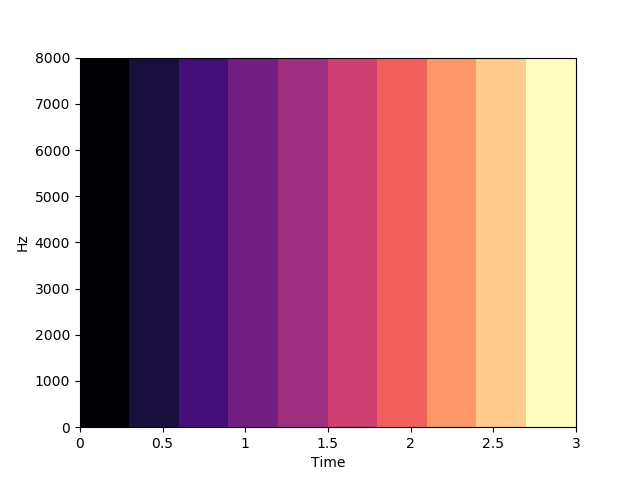

In [46]:
# Show how we cut the spectrogram in timexfrequency

Image("time.png")

In [47]:
# Load the explanation file

file = 'top_two_explanation_indices/time/spoof_FP_box.txt'   # using signal box

In [48]:
%%bash
cat top_two_explanation_indices/time/spoof_FP_box.txt  | head

3 4
5 3
7 6
6 7
3 6
4 5
2 6
7 3
5 4
3 5


In [49]:
def get_top1_top2_list(file):
    with open(file) as f:
        top1 = [int(line.strip().split(' ')[0]) for line in f]
    with open(file) as f:  
        top2 = [int(line.strip().split(' ')[1]) for line in f if int(line.strip().split(' ')[1]) != -999]
    return top1, top2    

In [50]:
# Get top1 and top2 in seperate list
top1, top2 = get_top1_top2_list(file)

In [51]:
print(top2)

[4, 3, 6, 7, 6, 5, 6, 3, 4, 5, 5, 5, 5, 2, 6, 5, 3, 3, 2, 4, 4, 2, 5, 5, 2, 4, 3, 5, 3, 4, 2]


In [52]:
print(len(top1))
print(len(top2))

31
31


In [53]:
def get_counts(datalist, key):
    count=0
    for i in range(0,len(datalist)):
        if datalist[i] == key:
            count+=1
    return count            

In [54]:
def print_component_distribution(comps, predList, order):
    print('Printing component weigting distribution for Top:', order)
    for i in comps:
        print('Component ' + str(i) + ' : ' + str(get_counts(predList, i)))    

In [55]:
comps=[0,1,2,3,4,5,6,7,8,9]    # In time we have 10 segments/components

In [56]:
# Print distribution on top1
order = 1
print_component_distribution(comps, top1, order)

Printing component weigting distribution for Top: 1
Component 0 : 0
Component 1 : 0
Component 2 : 6
Component 3 : 6
Component 4 : 2
Component 5 : 10
Component 6 : 5
Component 7 : 2
Component 8 : 0
Component 9 : 0


### Using the top1 components - given by SLIME (Time segmentation)

> With proper indexing and signal box

    Component 0 : 0
    Component 1 : 0
    Component 2 : 6
    Component 3 : 6
    Component 4 : 2
    Component 5 : 10
    Component 6 : 5
    Component 7 : 2
    Component 8 : 0
    Component 9 : 0
    
We see the exact behaviour we found for GENUINE class. These spoofed files for some reason seem to exhibit those patterns that were found for genuine files !!



> (with wrong indexing earlier) Using ***signal box and new specs*** we get following distribution (among 31 files)

    Component 0 : 0
    Component 1 : 0
    Component 2 : 7
    Component 3 : 11
    Component 4 : 2
    Component 5 : 7
    Component 6 : 4
    Component 7 : 0
    Component 8 : 0
    Component 9 : 0
    
This behaviour/pattern completely matches with what we found for a Genuine class frequency segmentation analysis. There we found top components as: 3,5,2. Here also we see same patter. Thus our analysis seems correct and answers too.    
    

# Pick 5 audio files for hearing

In [57]:
#random_5_ids = [124,170,150,103,135]   # Spoof misclassified as genuine with >90% probability
#add 1 to each to access correct file index in real world

#random_5_ids = [125,171,151,104,136] 
#base='/homes/bc305/myphd/datasets/ASVSpoof2017_v2.0/ASVspoof2017_V2_dev/'

In [58]:
%%bash
#cp /homes/bc305/myphd/datasets/ASVSpoof2017_v2.0/ASVspoof2017_V2_dev/D_1000136.wav audio_files_hearing/spoof_FP/

#ls audio_files_hearing/spoof_FP/

### Note: 
> the file topExplanation_list_spoof_TP.txt will have four columns
> The first column denotes file index (index from 0), second and third specifies genuine and spoofed probability, while last specifies the LLR score



## Analysing Freq: The top two components from SLIME - True positive Spoofed

Note, that under frequency analysis, we have cut our input spectrogram into 8 different frequency components/segments, where each segment correpsonds to

> ***1000 Hz frequency***

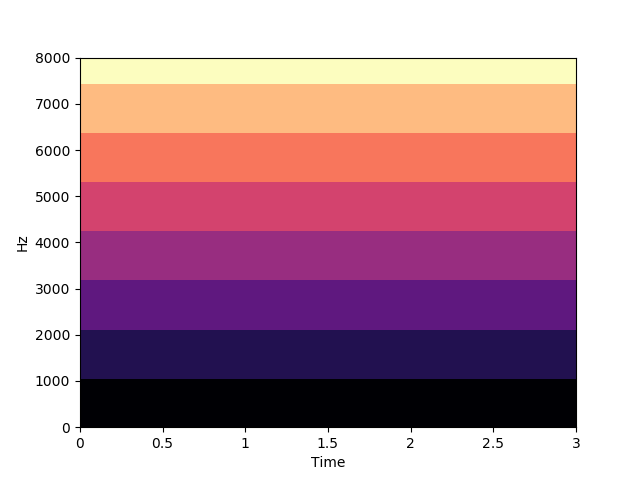

In [59]:
# Show how we cut the spectrogram in timexfrequency

Image("frequency.png")

In [60]:
# Get the explanation file

file = 'top_two_explanation_indices/freq/spoof_FP_box.txt'  # using signal box

In [61]:
%%bash
cat 'top_two_explanation_indices/freq/spoof_FP_box.txt' | head

# the top two components 7 6 dominates the explanation

7 5
7 6
7 6
7 6
7 6
7 6
7 6
7 6
7 6
7 6


In [62]:
# Get top1 and top2 in seperate list
top1, top2 = get_top1_top2_list(file)

In [63]:
print(len(top1))
print(len(top2))

31
31


## Top 1 component distribution - Frequency

In [64]:
comps = [0,1,2,3,4,5,6,7]   # in Frequency we have 8 components

In [65]:
# Print distribution on top1

order = 1
print_component_distribution(comps, top1, order)

Printing component weigting distribution for Top: 1
Component 0 : 0
Component 1 : 0
Component 2 : 0
Component 3 : 0
Component 4 : 0
Component 5 : 1
Component 6 : 0
Component 7 : 30


> With correct indexing, we see the same behaviour

    Component 0 : 0
    Component 1 : 0
    Component 2 : 0
    Component 3 : 0
    Component 4 : 0
    Component 5 : 1
    Component 6 : 0
    Component 7 : 30



> (with wrong indexing we had)***New Spectrograms using signal box*** and corrected label explanation

    Component 0 : 0
    Component 1 : 0
    Component 2 : 0
    Component 3 : 0
    Component 4 : 0
    Component 5 : 1
    Component 6 : 0
    Component 7 : 30
    
    
From above we get a clear cut answer about why these spoofed audio files were misclassified as genuine. The frequency analysis shows strong emphasis on the higher frequency components (8000hz frequency information). This matches with our genuine class definition !!! Yay !    

> Old specs without box (need to rerun as earlier we were using wrong labels for explanation)


***Observation***

Out of total 31 spoofed misclassified files with 90% probability for genuine class
 1. 30 belongs to Component 8 (8000Hz, which is the class indicator for genuine class)
 

# Pick 5 audio files for hearing

In [66]:
#random_5_ids = [671,942,134,139,160]   # Spoof misclassified as genuine with >90% probability
#add 1 to each to access correct file index in real world

#random_5_ids = [672,943,135,140,161]
#base='/homes/bc305/myphd/datasets/ASVSpoof2017_v2.0/ASVspoof2017_V2_dev/'

In [67]:
%%bash
#cp /homes/bc305/myphd/datasets/ASVSpoof2017_v2.0/ASVspoof2017_V2_dev/D_1000161.wav audio_files_hearing/spoof_FP/

#ls audio_files_hearing/spoof_FP/